In [1]:
pip install -U langgraph==0.2.4 langsmith langchain-openai langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.9/393.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.

In [2]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [3]:
from typing import List
from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI

获取提示词模版所需的信息

In [4]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])

chain = get_messages_info | llm_with_tool

获取工具调用返回的结构化数据，根据结构化数据生成提示词模版

In [5]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# 获取用于生成提示（prompt）的消息
# 只获取在工具调用（tool call）之后的消息
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


prompt_gen_chain = get_prompt_messages | llm

1. 如果是llm返回的消息，请求调用工具，执行工具；
2. 不是人工消息，并且不是工具调用。提示词模版（工具返回、按照用户需求修改后的），返回给用户。
3. 是人工消息，从消息中提取生成提示词模版的信息

In [6]:
from typing import Literal

from langgraph.graph import END

def get_state(messages) -> Literal["add_tool_message", "info", "__end__"]:
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [7]:
from langgraph.graph import START, MessageGraph
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
workflow = MessageGraph()
# 获取提示词模版的信息
workflow.add_node("info", chain)
# 生成提示词模版
workflow.add_node("prompt", prompt_gen_chain)

# 调用工具节点
@workflow.add_node
def add_tool_message(state: list):
    return ToolMessage(
        content="Prompt generated!", tool_call_id=state[-1].tool_calls[0]["id"]
    )

# 条件边
workflow.add_conditional_edges("info", get_state)
# 普通边
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

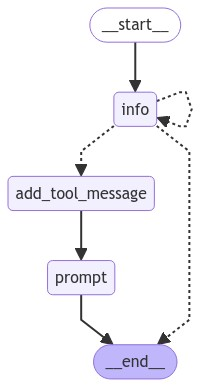

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        [HumanMessage(content=user)], config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): I would like to generate a multilingual translation prompt template.
================================== Ai Message ==================================

To help you create a multilingual translation prompt template, I need some additional information:

1. What is the objective of the prompt? (e.g., translating text, providing context for translation, etc.)
2. What variables will be passed into the prompt template? (e.g., source language, target language, text to translate, etc.)
3. Are there any constraints for what the output should NOT do? (e.g., avoid slang, do not translate idioms literally, etc.)
4. What requirements must the output adhere to? (e.g., maintain original meaning, use formal language, etc.)

Please provide these details!
User (q/Q to quit): Use the method of translation -> reflection -> paraphrase to translate different languages.
================================== Ai Message ==================================

Thank you for the information! However,